## Preparation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [ ]:
# device check(CFDLab)
device=torch.device('cuda:1') #先調1再調0
print(torch.cuda.is_available())
x=torch.randn(100).to(device) # Gives warning

In [ ]:
device=torch.device('cuda:0') # Fix warning
x=torch.randn(100).to(device) # No warning

In [2]:
# device check(my pc)
device=torch.device('cuda')
print(torch.cuda.is_available())
x=torch.randn(100).to(device) # No warning

True


## Parameters

In [3]:
batch=100 #batchsize
opt=1 # optimizer 1: Adams, better
tol=1e-2 # tolerance
n=[6400, 1000, 1000, 1000, 1000, 1000, 6400] #model layout
PATH= "ABS_UNS_FCN_TEST" # model name, saved as..

## Data

In [4]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
x_in=torch.Tensor(data_in)
x_in=x_in.to(device)

In [5]:
x=x_in
print(x.size())

torch.Size([1000, 6400])


In [6]:
loader=DataLoader(TensorDataset(x, x), batch_size=batch)

## Model

In [7]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, A, B, C, D, E, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, A)
        self.linear_2=torch.nn.Linear(A, B)
        self.linear_4=torch.nn.Linear(B, C)
        self.linear_5=torch.nn.Linear(C, D)
        self.linear_6=torch.nn.Linear(D, E)
        self.linear_3=torch.nn.Linear(E, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        a=self.linear_1(x)
        a_relu=torch.nn.functional.relu(a) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(a_relu) 
        b_relu=torch.nn.functional.relu(b)
        c=self.linear_4(b_relu) 
        c_relu=torch.nn.functional.relu(c)
        d=self.linear_5(c_relu) 
        d_relu=torch.nn.functional.relu(d)
        e=self.linear_6(d_relu) 
        e_relu=torch.nn.functional.relu(e)
        y_pred=self.linear_3(e_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6400, A=n[1], B=n[2], C=n[3], D=n[4], E=n[5], D_out=6400)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

## Training

In [8]:
if opt==0:
    optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
elif opt==1:
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

In [9]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)
        
        # Compute laplacian
        x_2d= torch.nn.Sequential(torch.nn.Unflatten(1, (1,80,80)))(x_batch)
        y_pred= torch.nn.Sequential(torch.nn.Unflatten(1, (80,80)))(y_pred)
        
        z=torch.concat([y_pred[:, :, :1], y_pred], axis=2)[:, :, :80]
        w=torch.concat([y_pred, y_pred[:, :, 79:]], axis=2)[:, :, 1:]
        m=torch.concat([y_pred[:, :1, :], y_pred], axis=1)[:, :80, :]
        n=torch.concat([y_pred, y_pred[:, 79:, :]], axis=1)[:, 1:, :]
        L_y_pred=(z+w+m+n-4*y_pred)*40 # h=1/80 /2h=>*40
        
        # fix dimension: [100, 1, 80, 80]-> [100, 80, 80]
        x_2d=x_2d.resize_(100, 80, 80)
        
        loss=torch.nn.functional.mse_loss(L_y_pred, x_2d)
        
        # Backward pass
        loss.requires_grad_(True)
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
        #print("1 batch")
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss


/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epochs:  1 ; Loss:  0.42924392223358154
Epochs:  2 ; Loss:  0.14946137368679047
Epochs:  3 ; Loss:  0.09619712829589844
Epochs:  4 ; Loss:  0.06431791931390762
Epochs:  5 ; Loss:  0.05383986607193947
Epochs:  6 ; Loss:  0.04468438774347305
Epochs:  7 ; Loss:  0.03970177471637726
Epochs:  8 ; Loss:  0.0359182246029377
Epochs:  9 ; Loss:  0.0328957624733448
Epochs:  10 ; Loss:  0.030394772067666054
Epochs:  11 ; Loss:  0.028291894122958183
Epochs:  12 ; Loss:  0.026444151997566223
Epochs:  13 ; Loss:  0.024853192269802094
Epochs:  14 ; Loss:  0.02345200441777706
Epochs:  15 ; Loss:  0.022206345573067665
Epochs:  16 ; Loss:  0.021089773625135422
Epochs:  17 ; Loss:  0.02007913962006569
Epochs:  18 ; Loss:  0.01915944553911686
Epochs:  19 ; Loss:  0.01832069829106331
Epochs:  20 ; Loss:  0.017546599730849266
Epochs:  21 ; Loss:  0.016827944666147232
Epochs:  22 ; Loss:  0.01614866964519024
Epochs:  23 ; Loss:  0.015513557009398937
Epochs:  24 ; Loss:  0.014917359687387943
Epochs:  25 ; Los

AttributeError: 'float' object has no attribute 'item'

## Result

In [10]:
# Append name with time
from datetime import datetime
ct=datetime.now()
ctime="_"+str(ct.year)+str(ct.month)+str(ct.day)+"_"+str(ct.hour)+str(ct.minute)+str(ct.second)
PATH="./result/"+PATH+ctime+".pth"

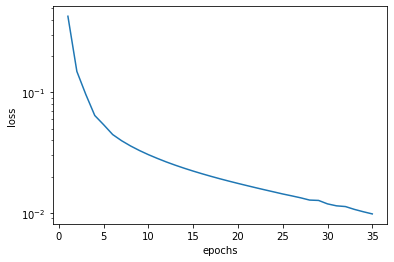

In [11]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()
plt.savefig(PATH+'.png')

## Export

In [12]:
device=torch.device('cpu')
model=model.to(device)
traced_net=torch.jit.trace(model, (torch.randn(1,6400)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)